In [217]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
import keras
from warnings import simplefilter
simplefilter("ignore")
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=16, titlepad=10)
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)
%config InlineBackend.figure_format = 'retina'
np.random.seed(42)

In [45]:
# define train test split function
def train_test_datasets(df, x_len=12, y_len=1, test_loops=12):
    D = df.values
    rows, periods = D.shape
    
    # Training set creation
    loops = periods + 1 - x_len - y_len
    train = []
    for col in range(loops):
        train.append(D[:, col:col+x_len+y_len])
    train = np.vstack(train)
    X_train, y_train = np.split(train, [-y_len], axis=1)

    # Test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows*test_loops], axis=0)
        y_train, y_test = np.split(y_train, [-rows*test_loops], axis=0)
    else: # No test set: X_test is used to generate the future forecast
        X_test = D[:, -x_len:]     
        y_test = np.full((X_test.shape[0], y_len), np.nan) #Dummy value
    
    # Formatting required for scikit-learn
    if y_len == 1: 
        y_train = y_train.ravel()
        y_test = y_test.ravel()  
        
    return X_train, y_train, X_test, y_test

# define score metric function
def kpi(y_train, y_train_pred, y_test, y_test_pred, name=''):
    df = pd.DataFrame(columns = ['MAE','RMSE', 'Bias', 'MAE_pct', 'RMSE_pct', 'r2_score'], index=['Train','Test'])
    df.index.name = name
    df.loc['Train','MAE_pct'] = 100*np.mean(abs(y_train - y_train_pred))/np.mean(y_train)
    df.loc['Train','RMSE_pct'] = 100*np.sqrt(np.mean((y_train - y_train_pred)**2))/np.mean(y_train)
    df.loc['Train','Bias'] = 100*np.mean((y_train - y_train_pred))/np.mean(y_train)
    df.loc['Train','r2_score'] =  r2_score(y_train, y_train_pred)
    df.loc['Train','MAE'] = mean_absolute_error(y_train, y_train_pred)
    df.loc['Train','RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
    df.loc['Test','MAE_pct'] = 100*np.mean(abs(y_test - y_test_pred))/np.mean(y_test) 
    df.loc['Test','RMSE_pct'] = 100*np.sqrt(np.mean((y_test - y_test_pred)**2))/np.mean(y_test)
    df.loc['Test','Bias'] = 100*np.mean((y_test - y_test_pred))/np.mean(y_test)
    df.loc['Test','r2_score'] =  r2_score(y_test, y_test_pred)
    df.loc['Test','MAE'] = mean_absolute_error(y_test, y_test_pred)
    df.loc['Test','RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)
    df = df.astype(float).round(2) #Round number for display
    print(df)

In [442]:
data = pd.read_csv('norway_new_car_sales_by_make.csv')
data.tail()

,Year,Month,Make,Quantity,Pct
3947,2016,1,Smart,6,0.1
3948,2016,1,Fiat,5,0.0
3949,2016,1,Jeep,4,0.0
3950,2016,1,Dacia,1,0.0
3951,2016,1,Maserati,1,0.0


In [443]:
data['Period'] = data.Year.astype(str) + '-' + data.Month.astype(str).str.zfill(2)

In [444]:
data.head()

,Year,Month,Make,Quantity,Pct,Period
0,2007,1,Toyota,2884,22.7,2007-01
1,2007,1,Volkswagen,2521,19.9,2007-01
2,2007,1,Peugeot,1029,8.1,2007-01
3,2007,1,Ford,870,6.9,2007-01
4,2007,1,Volvo,693,5.5,2007-01


In [445]:
data.isnull().sum()

Year         0
Month        0
Make        10
Quantity     0
Pct          0
Period       0
dtype: int64

In [446]:
data[data.Make.isnull()] # There is months with out cars sales we will fill 0

,Year,Month,Make,Quantity,Pct,Period
37,2007,1,NaN,1,0.0,2007-01
112,2007,3,NaN,1,0.0,2007-03
265,2007,7,NaN,1,0.0,2007-07
419,2007,11,NaN,1,0.0,2007-11
1256,2009,9,NaN,4,0.0,2009-09
1294,2009,10,NaN,4,0.0,2009-10
2399,2012,4,NaN,1,0.0,2012-04
2478,2012,6,NaN,1,0.0,2012-06
2517,2012,7,NaN,1,0.0,2012-07
3013,2013,9,NaN,1,0.0,2013-09


In [447]:
df = pd.pivot_table(data=data, values='Quantity', index='Make', columns='Period', aggfunc='sum', fill_value=0)
df.head()

Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,16,9,21,20,17,21,14,12,15,10,...,3,3,3,9,4,5,0,3,3,0
Aston Martin,0,0,1,0,4,3,3,0,0,0,...,2,2,0,0,0,0,0,0,0,0
Audi,599,498,682,556,630,498,562,590,393,554,...,665,585,640,754,541,494,549,592,496,559
BMW,352,335,365,360,431,477,403,348,271,562,...,733,693,849,617,860,777,1010,934,1024,1089
Bentley,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [448]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, Alfa Romeo to Westfield
Columns: 109 entries, 2007-01 to 2016-01
dtypes: int64(109)
memory usage: 55.9+ KB


In [449]:
df.shape

(65, 109)

## Linear Regression

In [450]:
# Linear Regression as first model to compare

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=12)

reg = Pipeline([('scaler', MinMaxScaler()), ('LinearRegression', LinearRegression())]) # Create a linear regression object

reg.fit(X_train, y_train) # Fit it to the training data

# Create two predictions for the training and test sets
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='Regression')

              MAE   RMSE  Bias  MAE_pct  RMSE_pct  r2_score
Regression                                                 
Train       29.50  73.02  -0.0    17.91     44.32      0.95
Test        33.56  80.90   0.9    17.32     41.75      0.95


## Random Forest

In [209]:
# use Random Forest with default parameters

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=12)

forest = Pipeline([('scaler', MinMaxScaler()), ('Forest', RandomForestRegressor())])

forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train) 
y_test_pred = forest.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='Forest')

          MAE   RMSE  Bias  MAE_pct  RMSE_pct  r2_score
Forest                                                 
Train   11.23  28.60 -0.14     6.67     16.99      0.99
Test    35.00  89.76  1.97    17.43     44.69      0.95


In [215]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=12)

pipe_grid = Pipeline([('scaler', MinMaxScaler()), ('Forestb', RandomForestRegressor(n_jobs=1))])

param_dist = {'Forestb__n_estimators': list(range(100, 500, 100)),
              'Forestb__max_depth': list(range(1, 20)) + [None],
              'Forestb__min_samples_split': range(2, 20),
              'Forestb__min_samples_leaf': range(1, 20),
              'Forestb__max_features': [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1] + ['auto'],
              'Forestb__bootstrap': [True],
              'Forestb__max_samples': [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]}

forest_cv = RandomizedSearchCV(pipe_grid, param_dist, cv=6, n_jobs=-1, verbose=1, n_iter=400)

forest_cv.fit(X_train, y_train)

print('Tuned Forest Parameters:', forest_cv.best_params_)

Fitting 6 folds for each of 400 candidates, totalling 2400 fits
Tuned Forest Parameters: {'Forestb__n_estimators': 100, 'Forestb__min_samples_split': 7, 'Forestb__min_samples_leaf': 6, 'Forestb__max_samples': 0.5, 'Forestb__max_features': 0.4, 'Forestb__max_depth': 19, 'Forestb__bootstrap': True}


In [216]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=12)

pipe_grid_f = Pipeline([('scaler', MinMaxScaler()), ('Forestf', RandomForestRegressor(n_jobs=1))])

param_dist_f = {'Forestf__n_estimators': [100],
                'Forestf__max_depth': list(range(17, 22)) + [None],
                'Forestf__min_samples_split': range(5, 10),
                'Forestf__min_samples_leaf': range(4, 9),
                'Forestf__max_features': [.35, .4, .45],
                'Forestf__bootstrap': [True],
                'Forestf__max_samples': [.45, .5, .55]}

forest_cv_f = GridSearchCV(pipe_grid_f, param_dist_f, n_jobs=-1, verbose=1)

forest_cv_f.fit(X_train, y_train)

print('Tuned Forest Parameters:', forest_cv_f.best_params_)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
Tuned Forest Parameters: {'Forestf__bootstrap': True, 'Forestf__max_depth': 19, 'Forestf__max_features': 0.4, 'Forestf__max_samples': 0.5, 'Forestf__min_samples_leaf': 5, 'Forestf__min_samples_split': 5, 'Forestf__n_estimators': 100}


In [457]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=20)

forest_final = Pipeline([('scaler', MinMaxScaler()), ('ForestFinal', RandomForestRegressor(n_estimators=100, 
                                                                                           min_samples_split=5, 
                                                                                           min_samples_leaf=5, 
                                                                                           max_samples=0.5, 
                                                                                           max_features=0.4, 
                                                                                           max_depth=19, 
                                                                                           bootstrap=True))])

forest_final.fit(X_train, y_train)  
 
y_train_pred = forest_final.predict(X_train)
y_test_pred = forest_final.predict(X_test) 
kpi(y_train, y_train_pred, y_test, y_test_pred, name='forest_final')

                MAE   RMSE  Bias  MAE_pct  RMSE_pct  r2_score
forest_final                                                 
Train         23.53  60.29 -0.07    14.42     36.96      0.97
Test          34.27  94.47  1.89    18.19     50.14      0.94


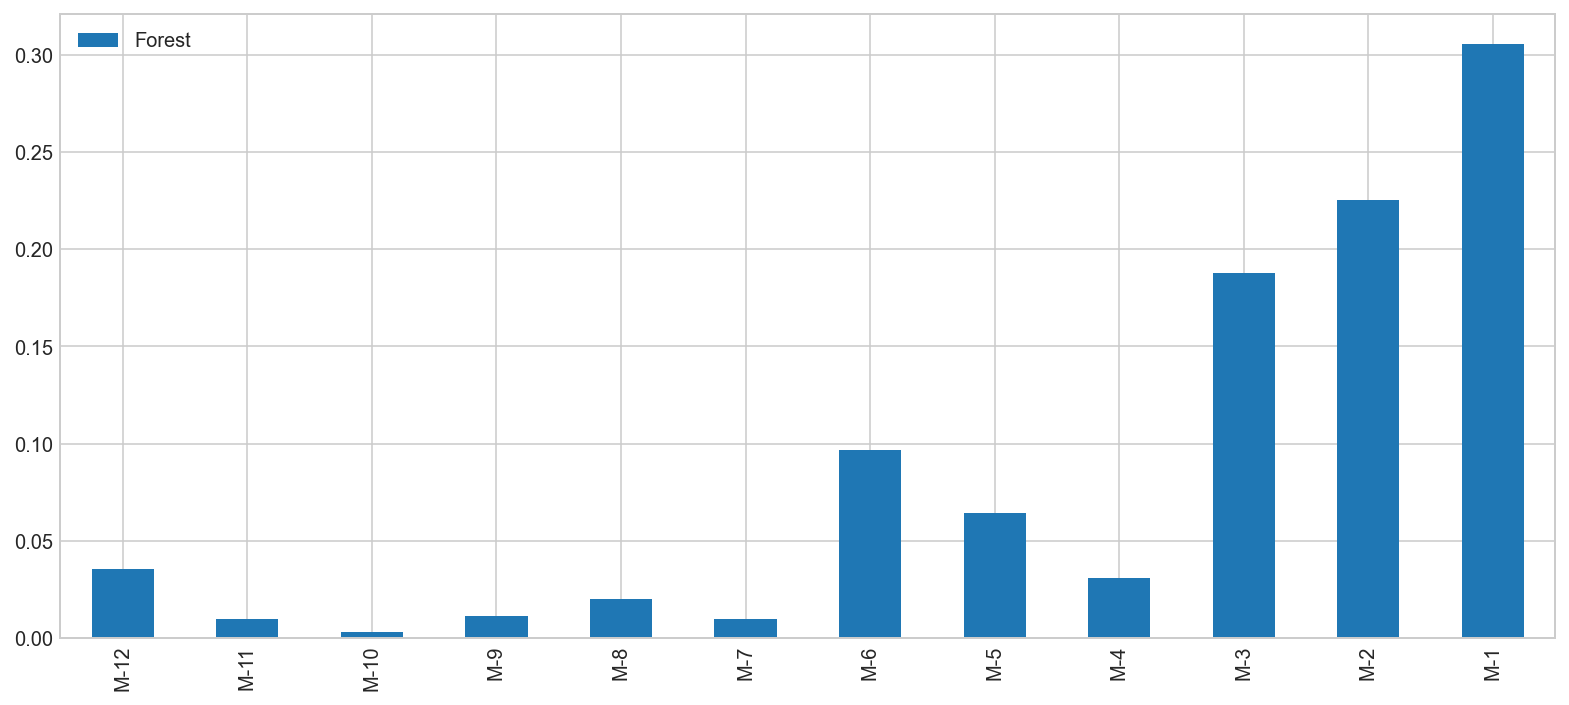

In [452]:
cols = X_train.shape[1]
features = [f'M-{cols-col}' for col in range(cols)]  
data = forest_final.steps[1][1].feature_importances_.reshape(-1,1)
imp = pd.DataFrame(data=data, index=features, columns=['Forest'])
imp.plot(kind='bar'); # the most important months is the first previous three months

In [456]:
# prediction

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=0)

forest_final = Pipeline([('scaler', MinMaxScaler()), ('ForestFinal', RandomForestRegressor(n_estimators=100, 
                                                                                           min_samples_split=5, 
                                                                                           min_samples_leaf=5, 
                                                                                           max_samples=0.5, 
                                                                                           max_features=0.4, 
                                                                                           max_depth=19, 
                                                                                           bootstrap=True))])

forest_final.fit(X_train, y_train)

forecast = pd.DataFrame(data=forest_final.predict(X_test), index=df.index, columns=['Next_Sales'])
forecast.tail(10)

,Next_Sales
Make,
Subaru,273.765626
Suzuki,246.159222
Tata,0.035983
Tazzari,0.035983
Tesla,238.629376
Think,0.035983
Toyota,1279.202421
Volkswagen,1980.871566
Volvo,754.306872


## sklearn neural network

In [239]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=12)

param_fixed = {'NN__activation': 'relu', 
               'NN__solver': 'adam', 
               'NN__early_stopping': True, 
               'NN__n_iter_no_change': 50, 
               'NN__validation_fraction': .1, 
               'NN__tol': .0001}

NN_b = Pipeline([('scaler', MinMaxScaler()), 
                 ('NN', MLPRegressor(hidden_layer_sizes=(20, 20), **param_fixed, verbose=True))])

NN_b.fit(X_train, y_train)

y_train_pred = NN_b.predict(X_train) 
y_test_pred = NN_b.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='NN_b')  

Iteration 1, loss = 16971.36834111
Validation score: 0.920519
Iteration 2, loss = 5110.23720794
Validation score: 0.931789
Iteration 3, loss = 4565.24989091
Validation score: 0.939719
Iteration 4, loss = 3852.89505267
Validation score: 0.947731
Iteration 5, loss = 3449.10170482
Validation score: 0.952096
Iteration 6, loss = 3265.13428419
Validation score: 0.953008
Iteration 7, loss = 3209.02490989
Validation score: 0.954035
Iteration 8, loss = 3085.55584211
Validation score: 0.951573
Iteration 9, loss = 3064.69334411
Validation score: 0.954850
Iteration 10, loss = 3008.82441924
Validation score: 0.953426
Iteration 11, loss = 2999.89364823
Validation score: 0.954806
Iteration 12, loss = 2935.42363800
Validation score: 0.950930
Iteration 13, loss = 2945.29979431
Validation score: 0.952048
Iteration 14, loss = 2892.57673994
Validation score: 0.954456
Iteration 15, loss = 2898.20545926
Validation score: 0.953670
Iteration 16, loss = 2840.81105990
Validation score: 0.956535
Iteration 17, lo

In [240]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=12)

NN = Pipeline([('scaler', MinMaxScaler()), 
               ('NN', MLPRegressor(activation='relu', 
                                   solver='adam', 
                                   early_stopping=True, 
                                   n_iter_no_change=50, 
                                   validation_fraction=.1, 
                                   tol=.0001))])

param_dist = {'NN__hidden_layer_sizes': [[neuron]*hidden_layer for neuron in range(10,60,10) for hidden_layer in range(2,7)], 
              'NN__alpha': [5, 1, .5, .1, .05, .01, .001], 
              'NN__learning_rate_init': [.05, .01, .005, .001, .0005], 
              'NN__beta_1': [.85, .875, .9, .95, .975, .99, .995], 
              'NN__beta_2': [.99, .995, .999, .9995, .9999]}

NN_cv = RandomizedSearchCV(NN, param_dist, cv=10, verbose=2, n_jobs=-1, n_iter=200, scoring='neg_mean_absolute_error')
NN_cv.fit(X_train, y_train)

print('Tuned NN Parameters:', NN_cv.best_params_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Tuned NN Parameters: {'learning_rate_init': 0.005, 'hidden_layer_sizes': [30, 30, 30, 30, 30], 'beta_2': 0.995, 'beta_1': 0.975, 'alpha': 0.001}

                MAE   RMSE  Bias  MAE_pct  RMSE_pct  r2_score
NN optimized                                                 
Train         28.55  69.02 -3.51    16.96     41.00      0.96
Test          34.66  86.15 -1.91    17.25     42.89      0.95


In [469]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=20)

NN_final = Pipeline([('scaler', MinMaxScaler()), 
                     ('NN', MLPRegressor(activation='relu', 
                                         solver='adam', 
                                         early_stopping=True, 
                                         n_iter_no_change=50, 
                                         validation_fraction=.1, 
                                         tol=.0001, 
                                         hidden_layer_sizes=[30, 30, 30, 30, 30], 
                                         alpha=.001, 
                                         learning_rate_init=.005, 
                                         beta_1=.97, 
                                         beta_2=.995))])
NN_final.fit(X_train, y_train)

y_train_pred = NN_final.predict(X_train) 
y_test_pred = NN_final.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='NN Final')

            MAE   RMSE  Bias  MAE_pct  RMSE_pct  r2_score
NN Final                                                 
Train     29.25  72.58 -1.45    17.93     44.49      0.95
Test      32.10  82.84 -1.93    17.04     43.97      0.95


In [472]:
#Forecasting

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=0)

NN_final = Pipeline([('scaler', MinMaxScaler()), 
                     ('NN', MLPRegressor(activation='relu', 
                                         solver='adam', 
                                         early_stopping=True, 
                                         n_iter_no_change=50, 
                                         validation_fraction=.1, 
                                         tol=.0001, 
                                         hidden_layer_sizes=[30, 30, 30, 30, 30], 
                                         alpha=.001, 
                                         learning_rate_init=.005, 
                                         beta_1=.97, 
                                         beta_2=.995))])
NN_final.fit(X_train, y_train)

forecast = pd.DataFrame(data=NN_final.predict(X_test), index=df.index, columns=['Next_Sales'])
forecast.tail(10)

,Next_Sales
Make,
Subaru,237.845909
Suzuki,268.173489
Tata,0.988654
Tazzari,0.988654
Tesla,176.352180
Think,0.988654
Toyota,1151.028659
Volkswagen,1850.869401
Volvo,744.645220


### LSTM

In [511]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=3, y_len=1, test_loops=12)

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

n_steps = 3 # =x_len
n_features = 1

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5720, 3, 1), (1170, 3, 1), (5720, 1), (1170, 1))

In [512]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=60, 
                                                           kernel_size=5, 
                                                           strides=1, 
                                                           padding="causal", 
                                                           activation="relu", 
                                                           input_shape=(n_steps, n_features)), 
                                    tf.keras.layers.LSTM(60, return_sequences=True), 
                                    tf.keras.layers.LSTM(60), tf.keras.layers.Dense(1), 
                                    tf.keras.layers.Lambda(lambda x: x * 400)])


model.compile(loss='mean_squared_error',optimizer='adam')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100 ,batch_size=16, verbose=0)

In [514]:
y_train_pred = model.predict(X_train) 
y_test_pred = model.predict(X_test)

kpi(y_train, y_train_pred, y_test, y_test_pred, name='LSTM')

         MAE    RMSE  Bias  MAE_pct  RMSE_pct  r2_score
LSTM                                                   
Train  30.29   77.26 -1.80    18.53     47.26      0.94
Test   38.94  106.53  2.26    20.54     56.19      0.92


In [517]:
# Forecasting

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=3, y_len=1, test_loops=0)

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

n_steps = 3 # =x_len
n_features = 1

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [501]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model1 = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=60, 
                                                           kernel_size=5, 
                                                           strides=1, 
                                                           padding="causal", 
                                                           activation="relu", 
                                                           input_shape=(n_steps, n_features)), 
                                    tf.keras.layers.LSTM(60, return_sequences=True), 
                                    tf.keras.layers.LSTM(60), tf.keras.layers.Dense(1), 
                                    tf.keras.layers.Lambda(lambda x: x * 400)])


model1.compile(loss='mean_squared_error',optimizer='adam')

history = model1.fit(X_train, y_train, epochs=100 ,batch_size=16, verbose=0)

In [518]:
forecast = pd.DataFrame(data=model1.predict(X_test), index=df.index, columns=['Next_Sales'])
forecast.head()

,Next_Sales
Make,
Alfa Romeo,2.751791
Aston Martin,2.552545
Audi,507.842651
BMW,999.981812
Bentley,2.552545
